[*********************100%%**********************]  1 of 1 completed


Performing EDA...


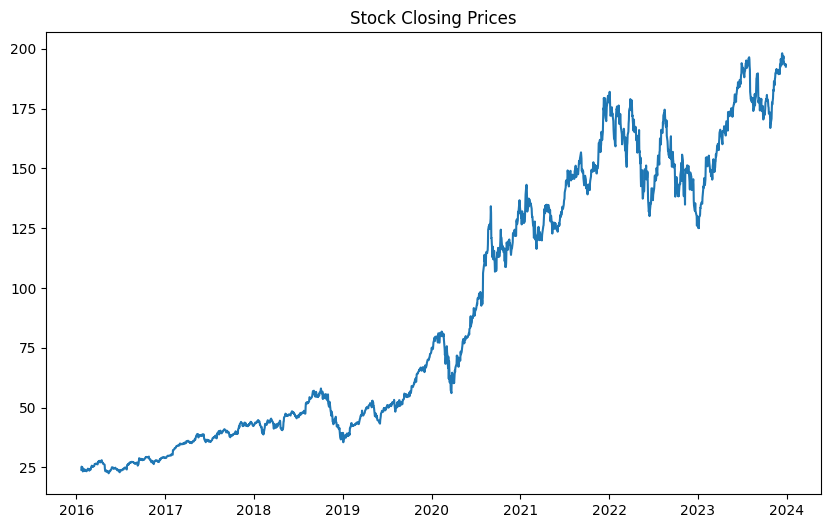

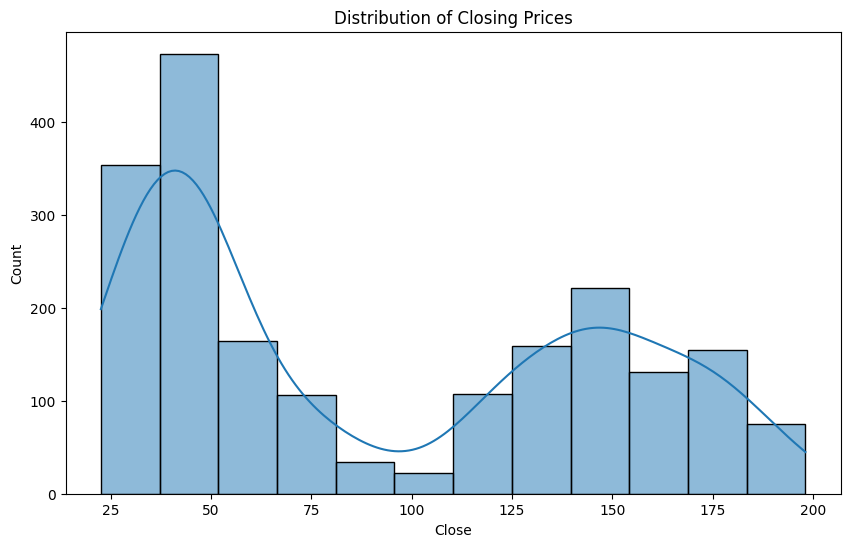

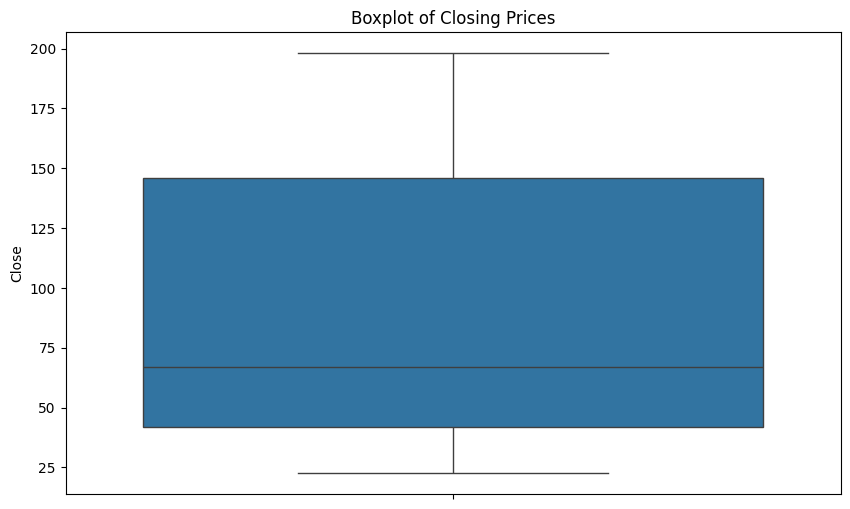

No Preprocessing


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Cannot convert '60' to a shape.

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization, Flatten, Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping

# Function to handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Load the dataset
ticker = 'AAPL'
data = yf.download(ticker, start='2000-01-01', end='2024-01-01')
data = data[['Close']].iloc[-2000:]  # Use the last 2000 rows
data = data.dropna()

# Exploratory Data Analysis (EDA)
print("Performing EDA...")
plt.figure(figsize=(10, 6))
plt.title("Stock Closing Prices")
plt.plot(data['Close'])
plt.show()

# Handling outliers
data = remove_outliers(data, 'Close')

# Univariate analysis
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], kde=True)
plt.title("Distribution of Closing Prices")
plt.show()

# Bivariate analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data['Close'])
plt.title("Boxplot of Closing Prices")
plt.show()

# Split the data
def split_data(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i].values[0])
    X, y = np.array(X), np.array(y)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    split_val = int(0.8 * len(X_train))
    X_train, X_val = X_train[:split_val], X_train[split_val:]
    y_train, y_val = y_train[:split_val], y_train[split_val:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# Preprocessing functions
def preprocess_standard_scaler(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train, X_val, X_test

def preprocess_minmax_scaler(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train, X_val, X_test

# Model Definitions with higher dropout and alternative activation functions
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(30, return_sequences=True, input_shape=input_shape, activation='relu'),
        Dropout(0.2),  # Increased dropout
        LSTM(30, return_sequences=False, activation='relu'),
        Dropout(0.2),  # Increased dropout
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model_transformer(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

def build_tcn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"),
        Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),  # Increased dropout
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_rf_model():
    model = RandomForestRegressor(n_estimators=100)
    return model

# Hyperparameter tuning for Random Forest using Grid Search
def tune_rf_hyperparameters(X_train, y_train):
    rf = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, None]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training and Evaluation Function
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_type):
    if model_type == 'RF':
        model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
        predictions = model.predict(X_test.reshape(X_test.shape[0], -1))
    else:
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
        predictions = model.predict(X_test)
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss - {model_type}')
        plt.legend()
        plt.show()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'RMSE {model_type}: {np.sqrt(mse)}')
    print(f'MAE {model_type}: {mae}')
    print(f'R² {model_type}: {r2}')

    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.title(f'Actual vs Predicted Stock Prices - {model_type}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Experiment Setup
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

# No Preprocessing
print("No Preprocessing")
lstm_model = build_lstm_model((X_train.shape[1]))
train_and_evaluate_model(lstm_model, X_train, y_train, X_val, y_val, X_test, y_test, 'LSTM')

# input_shape = X_train.shape[1:]
# model = build_model_transformer(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# tcn_model = build_tcn_model((X_train.shape[1], X_train.shape[2]))
# train_and_evaluate_model(tcn_model, X_train, y_train, X_val, y_val, X_test, y_test, 'TCN')

# rf_model = tune_rf_hyperparameters(X_train, y_train)
# train_and_evaluate_model(rf_model, X_train, y_train, X_val, y_val, X_test, y_test, 'RF')

# # Standard Scaling
# print("Standard Scaling")
# X_train_scaled, X_val_scaled, X_test_scaled = preprocess_standard_scaler(X_train, X_val, X_test)

# lstm_model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
# train_and_evaluate_model(lstm_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, 'LSTM')

# input_shape = X_train_scaled.shape[1:]
# model = build_model_transformer(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# tcn_model = build_tcn_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
# train_and_evaluate_model(tcn_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, 'TCN')

# rf_model = tune_rf_hyperparameters(X_train_scaled, y_train)
# train_and_evaluate_model(rf_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, 'RF')

# # Min-Max Scaling
# print("Min-Max Scaling")
# X_train_minmax, X_val_minmax, X_test_minmax = preprocess_minmax_scaler(X_train, X_val, X_test)

# lstm_model = build_lstm_model((X_train_minmax.shape[1], X_train_minmax.shape[2]))
# train_and_evaluate_model(lstm_model, X_train_minmax, y_train, X_val_minmax, y_val, X_test_minmax, y_test, 'LSTM')

# input_shape = X_train_minmax.shape[1:]
# model = build_model_transformer(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# tcn_model = build_tcn_model((X_train_minmax.shape[1], X_train_minmax.shape[2]))
# train_and_evaluate_model(tcn_model, X_train_minmax, y_train, X_val_minmax, y_val, X_test_minmax, y_test, 'TCN')

# rf_model = tune_rf_hyperparameters(X_train_minmax, y_train)
# train_and_evaluate_model(rf_model, X_train_minmax, y_train, X_val_minmax, y_val, X_test_minmax, y_test, 'RF')

